### Machine Learning

- Maria Zazpe Quintana

- Alba Rodríguez Berenguel

Este es el último notebook de nuestro proyecto y nos vamos a centrar en la interpretabilidad y explicabilidad del modelo. Esto es muy importante sobre todo si ponemos en práctica estos modelos u otras personas ajenas al proyecto los tienen que utilizar o buscar un razonamiento a en qué se basa principalmente el modelo al realizar las predicciones, las variables a las que les da más importancia, etc. Vamos a seguir la siguiente estructura:

1. Importación de librerías, funciones, datos y modelo.
2. Explicabilidad con SHAP.
3. Explicabilidad con SKLearn.
4. Conclusiones.

## 1. Importación de librerías, funciones, datos y modelo.

En primer lugar, vamos a cargar todo lo que necesitamos: **los datos, el modelo seleccionado y el modelo optimizado**, las librerías y las funciones.

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Functions
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [4]:
# Data
X_train = pd.read_csv("../data/processed/X_train.csv",index_col=0 )
y_train = pd.read_csv("../data/processed/y_train.csv",index_col=0 )

x_test = pd.read_csv("../data/processed/x_test.csv",index_col=0 )
y_test = pd.read_csv("../data/processed/y_test.csv",index_col=0 )

In [5]:
# Load model.
with open('../models/xgboost.pickle', 'rb') as f:
    xgb_model = pickle.load(f)
    
# Load model CV.
with open('../models/xgboost_grid.pickle', 'rb') as f:
    CV = pickle.load(f)

# Load preprocessor.
preprocessor = xgb_model.named_steps["preprocessor"]

## 2. Explicabilidad con SHAP.

Primero, necesitamos generar los valores necesarios para aplicarlos a SHAP y poder realizar visualizaciones. Al haber aplicado un preprocesador a nuestro modelo no podemos hacerlo con los datos originales, necesitamos esos datos que han pasado ya por el preprocesador.

In [14]:
# We get the feature names of the preprocessor with the function get_feature_names.
columns = get_feature_names(preprocessor)

#We transform x_test to obtain the x test with the preprocessor.
xtest = pd.DataFrame(CV.best_estimator_.named_steps['preprocessor'].transform(x_test), columns=columns)

# We get the best estimator of our classifier of the CV model.
model = CV.best_estimator_.named_steps['classifier']

explainer = shap.TreeExplainer(CV.best_estimator_.named_steps['classifier'])

shap_values = explainer.shap_values(xtest)

### Summary plot.

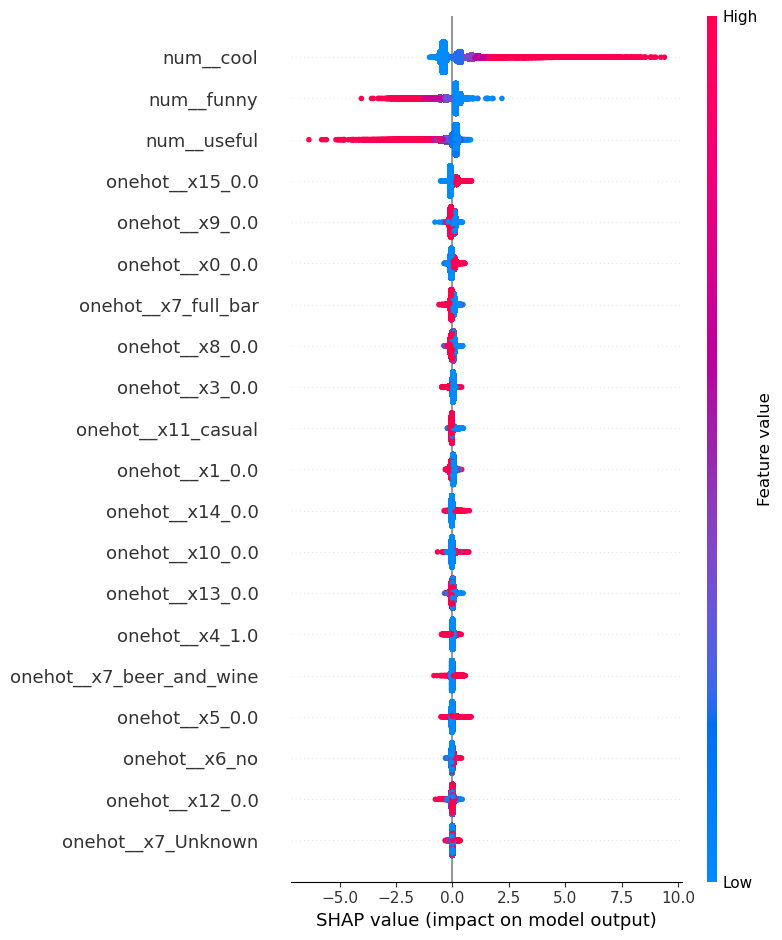

In [15]:
# Display the importance of each variable globally.
shap.summary_plot(shap_values, xtest)

En este gráfico vemos la importancia que ha asignado el modelo a las variables. En este caso las principales variables son:

- Cool. Cuantas más valoraciones *cool* reciba la reseña, mayor impacto supone para considerar que el restaurante tendrá de 4 a 5 estrellas.

- Funny. Cuantas más valoraciones *funny* reciba la reseña, menos afecta al modelo de forma positiva.

- Useful. Cuantas más valoraciones *useful* reciba la reseña, menor peso tiene para se considerado como 4 o 5 estrellas.

- Tv (Onehot15). Cuando toma un valor más alto (1), es más considerable que un restaurante obtenga una puntuación alta.

### Explicación individual de una reseña.

In [19]:
# We choose a observation which is 0 fot target value.
shap.force_plot(explainer.expected_value, shap_values[0], xtest.iloc[0,:])

En el caso de la observación 0, que el restaurante tiene una puntuación baja en la reseña, observamos que las variables que pesan más en el modelo para que sea así, son num__useful, num__funny y onehot__x8_0.0 que corresponde a la variable caters.

In [24]:
# We choose a observation which is 1 fot target value.
shap.force_plot(explainer.expected_value, shap_values[3], xtest.iloc[3,:])

En la observación 3, el restaurante reseñado ha obtenido una puntuación alta y es gracias a las variables num_cool, caters, tv, delivery y alcohol.

In [77]:
shap.force_plot(explainer.expected_value, shap_values[:100, :], features=xtest.iloc[:100, :])

En este gráfico interactivo podemos ver lo que hemos explicado anteriormente pero para 100 observaciones, y además, la relación entre variables.

## 3. Explicabilidad con SKLearn.

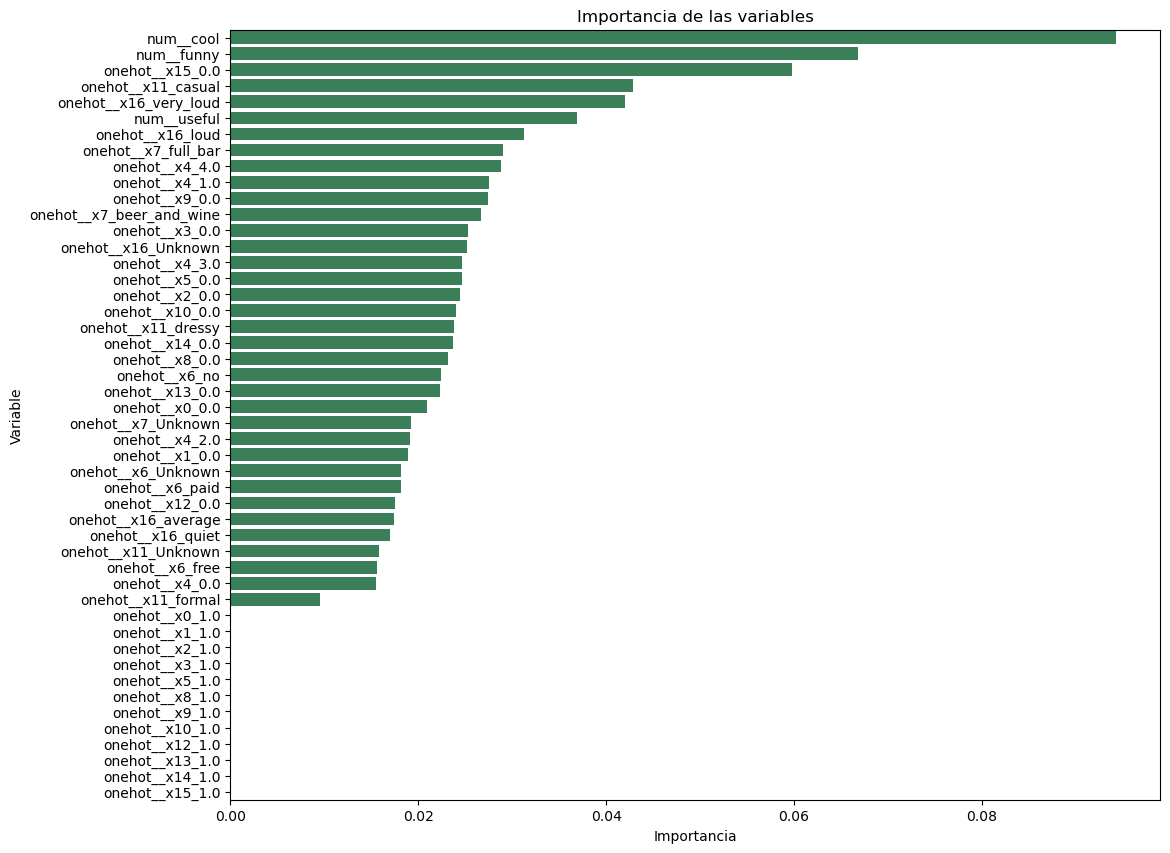

In [90]:
# Save the feature importances from the classifier.
importantVariables = CV.best_estimator_._final_estimator.feature_importances_

# Sort the variables by importance
importancia_variables = sorted(
                              list(zip(xtest.columns,
                                       importantVariables)),
    
    key=lambda tupla: tupla[1],
    reverse=True)

# Crate a data frame with the importance of each variable.
importancia_variables = pd.DataFrame(importancia_variables)
importancia_variables.rename(columns={ 0: 'Variable',  1: 'Importancia'}, inplace=True)

# Plot the results.
plt.figure(figsize=(12, 10))

sns.barplot(x='Importancia',
            y='Variable', 
            data=importancia_variables, 
            color='seagreen')

plt.title('Importancia de las variables');

Con este gráfico podemos corroborar lo que hemos visualizado con SHAP. Las variables que aportan son **cool, funny y tv**. Hay otras variables como *attire* (la vestimenta) que tiene mayor peso la casual; noise_level cuya categoría very_loud tiene mayor importancia, y loud también; alcohol también es importante, teniendo más importancia que tengan todos los alcoholes (full_bar)...

## 4. Conclusiones. 

Por último, queremos dar algunas conclusiones para cerrar este proyecto.

Las aplicaciones que tiene este modelo creemos que pueden ser principalmente para ver los atributos que más consideran los clientes en un restaurante y que los propios negocios puedan decidir cuáles de ellos implementar o mejorar para atraer más clientes.

Por otra parte, hemos visto que algunos de los atributos que mayor importancia aportan al modelo, y por tanto, se podría decir que son aquellos que los clientes tienen más en cuenta a la hora de poner una reseña son:

- Tv: Que el restaurante tenga televisión es de los más importantes. Son muchos los clientes que acuden a estos establecimientos para ver acontecimientos deportivos importantes en grupo, por lo que es importante que tengan televisión.


- Vestimenta: Esto dependerá más del tipo de cliente, pero se aprecia una preferencia por la vestimenta casual.


- Noise level: Esto dependerá del tipo de restaurante, pero los sonidos altos y muy altos son los que aportan más importancia al modelo.


- Alcohol: El alcohol, de todo tipo, es de las bebidas que más se consumen en los restaurantes. Que posean todo tipo de alcoholes es más importante.


- Rango de precios: Esto también es importante, los que mayor importancia tienen son los baratos y los caros.